In [1]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib.patches import PathPatch

import cosima_cookbook as cc

import xarray as xr
import numpy as np
import matplotlib as mpl
from matplotlib import gridspec
import matplotlib.path as mpath
import matplotlib.colors as mcolors

from matplotlib import ticker, cm
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import cmcrameri
import climtas.nci
import cmocean.cm as cmocean



import sys
sys.path.append("/g/data/x77/ps7863/python_scripts")
import helper_functions as helper

In [2]:
climtas.nci.GadiClient()

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 24
Total threads: 24,Total memory: 95.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:46307,Workers: 24
Dashboard: /proxy/8787/status,Total threads: 24
Started: Just now,Total memory: 95.00 GiB
Comm: tcp://127.0.0.1:37015,Total threads: 1
Dashboard: /proxy/35711/status,Memory: 3.96 GiB
Nanny: tcp://127.0.0.1:45781,


2025-03-04 10:39:09,450 - tornado.application - ERROR - Uncaught exception GET /individual-scheduler-system/ws (::1)
HTTPServerRequest(protocol='http', host='gadi-cpu-clx-1362.gadi.nci.org.au:48661', method='GET', uri='/individual-scheduler-system/ws', version='HTTP/1.1', remote_ip='::1')
Traceback (most recent call last):
  File "/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/tornado/web.py", line 1790, in _execute
    result = await result
  File "/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/tornado/websocket.py", line 273, in get
    await self.ws_connection.accept_connection(self)
  File "/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/tornado/websocket.py", line 863, in accept_connection
    await self._accept_connection(handler)
  File "/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/tornado/websocket.py", line 946, in _accept_con

In [3]:
figdir = '/g/data/x77/ps7863/figures/AABW_variability/'
session = cc.database.create_session('/g/data/ik11/databases/cosima_master.db')
iaf_cycle3 = '01deg_jra55v140_iaf_cycle3'
expt = '01deg_jra55v140_iaf_cycle3_antarctic_tracers'

In [4]:
# lon_slice = slice(80-360, 190-360)
lat_slice = slice(-82, -55)

degree =  u'\N{DEGREE SIGN}'

In [5]:
ht = cc.querying.getvar(iaf_cycle3,'ht',session, n=1) 
# ht = ht.sel(yt_ocean = lat_slice).sel(xt_ocean=lon_slice)
land_mask = np.squeeze(ht.values)
land_mask = land_mask * 0
land_mask[np.isnan(land_mask)] = 1
yt_ocean =ht.yt_ocean.values
xt_ocean =ht.xt_ocean.values
land_mask_masked = np.ma.masked_where((land_mask==0),land_mask)

In [6]:
shelf_mask = ht > 1000
shelf_mask = shelf_mask.astype(bool)
masked_shelf = shelf_mask.where(shelf_mask==0, np.nan)
shelf_mask = shelf_mask.where(shelf_mask==1, np.nan)
shelf_mask

<xarray.DataArray 'ht' (yt_ocean: 2700, xt_ocean: 3600)> Size: 78MB
dask.array<where, shape=(2700, 3600), dtype=float64, chunksize=(540, 720), chunktype=numpy.ndarray>
Coordinates:
  * xt_ocean  (xt_ocean) float64 29kB -279.9 -279.8 -279.7 ... 79.75 79.85 79.95
  * yt_ocean  (yt_ocean) float64 22kB -81.11 -81.07 -81.02 ... 89.89 89.94 89.98

In [7]:
xt_ocean = ht.xt_ocean
yt_ocean = ht.yt_ocean

In [8]:
X, Y = np.meshgrid(xt_ocean, yt_ocean)
X = xr.DataArray(X, coords=[yt_ocean, xt_ocean], dims=['yt_ocean', 'xt_ocean'])
Y = xr.DataArray(Y, coords=[yt_ocean, xt_ocean], dims=['yt_ocean', 'xt_ocean'])

In [9]:
def make_boundary_path(longitudes, latitudes):
    """
    Return a path around boundary to create a sector map, then cut it out given
    longitudes and latitudes.
    """

    boundary_path = np.array([longitudes[-1, :], latitudes[-1, :]])
    boundary_path = np.append(
        boundary_path, np.array([longitudes[::-1, -1], latitudes[::-1, -1]]), axis=1
    )
    boundary_path = np.append(
        boundary_path, np.array([longitudes[1, ::-1], latitudes[1, ::-1]]), axis=1
    )
    boundary_path = np.append(
        boundary_path, np.array([longitudes[:, 1], latitudes[:, 1]]), axis=1
    )
    boundary_path = mpath.Path(np.swapaxes(boundary_path, 0, 1))

    return boundary_path

In [10]:
# To plot 1000-m contour
contour_file = np.load('/g/data/ik11/grids/Antarctic_slope_contour_1000m.npz')
shelf = contour_file['contour_masked_above']
yt_ocean = contour_file['yt_ocean']
xt_ocean = contour_file['xt_ocean']
# Mask values that are non-zero
shelf[np.where(shelf!=0)] = np.nan
shelf = shelf+1
shelf = np.nan_to_num(shelf)
shelf = xr.DataArray(shelf, coords = [('yt_ocean', yt_ocean), ('xt_ocean', xt_ocean)])

In [15]:
land_50m = cfeature.NaturalEarthFeature(
    "physical", "land", "50m", edgecolor="black", facecolor="grey", linewidth=0.5
)

In [12]:
first_year = 1990
last_year = 2018
start_time = f'01-01-{first_year}'
end_time = f'31-12-{last_year}'
time_slice = slice(start_time, end_time)

In [13]:
albw = xr.open_dataset('/g/data/x77/ps7863/data/AABW_variability/ALBW_tracer_bottom_500_1958-2018.nc')
rsbw = xr.open_dataset('/g/data/x77/ps7863/data/AABW_variability/RSBW_tracer_bottom_500_1958-2018.nc')
albw = albw['ALBW_tracer']
rsbw = rsbw['RSBW tracer']

In [14]:
albw = albw.sel(time=time_slice)
rsbw = rsbw.sel(time=time_slice)

## Load previously computed SWMT data

In [16]:
adelie_SWMT = xr.open_dataset('/g/data/x77/ps7863/data/SWMT_plot/adelie_SWMT.nc')
ross_SWMT = xr.open_dataset('/g/data/x77/ps7863/data/SWMT_plot/ross_SWMT.nc')

In [17]:
adelie_SWMT = adelie_SWMT['adelie_swmt']
ross_SWMT = ross_SWMT['ross_swmt']

## Load previously computed SWMT data

In [18]:
yt_ocean = ht.yt_ocean.values
xt_ocean = ht.xt_ocean.values

In [19]:
outpath = '/g/data/x77/ps7863/data/SWMT_temp'

In [20]:
# time_bounds = str(salt_transformation.coords['time.year'][0].values)+'_'+str(salt_transformation.coords['time.month'][0].values)+'-'+str(salt_transformation.coords['time.year'][-1].values)+'_'+str(salt_transformation.coords['time.month'][-1].values)
time_bounds='1990_1-2018_12'

In [21]:
def get_SWMT(outpath, time_bounds):

    net_transformation = xr.open_dataset(outpath + '/SWMT_' + time_bounds + '.nc', chunks={'isopycnal_bins':1})
    net_transformation = net_transformation.surface_water_mass_transformation
    heat_transformation = xr.open_dataset(outpath + '/HT_' + time_bounds + '.nc', chunks={'isopycnal_bins':1})
    heat_transformation = heat_transformation.binned_heat_transformation
    salt_transformation = xr.open_dataset(outpath + '/ST_' + time_bounds + '.nc', chunks={'isopycnal_bins':1})
    salt_transformation = salt_transformation.binned_salt_transformation

    return net_transformation, heat_transformation, salt_transformation

In [22]:
def shelf_mask_isobath(var):
    '''
    Masks ACCESS-OM2-01 variables by the region polewards of the 1000m isobath as computed using 
    a script contributed by Adele Morrison.
    Only to be used with ACCESS-OM2-0.1 output!
    '''
    contour_file = np.load('/g/data/ik11/grids/Antarctic_slope_contour_1000m.npz')
    
    shelf_mask = contour_file['contour_masked_above']
    yt_ocean = contour_file['yt_ocean']
    xt_ocean = contour_file['xt_ocean']
    
    # in this file the points along the isobath are given a positive value, the points outside (northwards) 
    # of the isobath are given a value of -100 and all the points on the continental shelf have a value of 0 
    # so we mask for the 0 values 
    shelf_mask[np.where(shelf_mask!=0)] = np.nan
    shelf_mask = shelf_mask+1
    shelf_map  = np.nan_to_num(shelf_mask)
    shelf_mask = xr.DataArray(shelf_mask, coords = [('yt_ocean', yt_ocean), ('xt_ocean', xt_ocean)])
    shelf_map  = xr.DataArray(shelf_map,  coords = [('yt_ocean', yt_ocean), ('xt_ocean', xt_ocean)])
    
    # then we want to multiply the variable with the mask so we need to account for the shape of the mask. 
    # The mask uses a northern cutoff of 59S.
    masked_var = var.sel(yt_ocean = slice(-90, -59.03)) * shelf_mask

    return masked_var, shelf_map

In [23]:
ht_shelf, shelf_mask = shelf_mask_isobath(ht)

In [24]:
area_t = cc.querying.getvar(iaf_cycle3, 'area_t', session, n=1) # needed for the plots I'll provide.
swmt, heat, salt = get_SWMT(outpath, time_bounds)

## sum over region, convert to Sv
isopycnal_bin_mid = swmt.isopycnal_bins
swmt_sum = (swmt * area_t / 1e6).sum(['xt_ocean', 'yt_ocean']).values
heat_sum = (heat * area_t / 1e6).sum(['xt_ocean', 'yt_ocean']).values
salt_sum = (salt * area_t / 1e6).sum(['xt_ocean', 'yt_ocean']).values

In [25]:
swmt_shelf, shelf_mask = shelf_mask_isobath(swmt)
heat_shelf, shelf_mask = shelf_mask_isobath(heat)
salt_shelf, shelf_mask = shelf_mask_isobath(salt)
area_t_shelf, shelf_mask = shelf_mask_isobath(area_t)
swmt_shelf_sum = (swmt_shelf * area_t_shelf / 1e6).sum(['xt_ocean', 'yt_ocean']).values
heat_shelf_sum = (heat_shelf * area_t_shelf / 1e6).sum(['xt_ocean', 'yt_ocean']).values
salt_shelf_sum = (salt_shelf * area_t_shelf / 1e6).sum(['xt_ocean', 'yt_ocean']).values

In [26]:
weddell_transformation_density = 32.65

weddell_shelf_subduction_plot = swmt_shelf.sel(isopycnal_bins = weddell_transformation_density, method='nearest') * 1e5
weddell_swmt_xt = weddell_shelf_subduction_plot.xt_ocean
weddell_swmt_yt = weddell_shelf_subduction_plot.yt_ocean

In [27]:
weddell_shelf_subduction_plot = weddell_shelf_subduction_plot.sel(xt_ocean=slice(-80,-30), yt_ocean=lat_slice)
weddell_swmt_xt = weddell_swmt_xt.sel(xt_ocean=slice(-80,-30))
weddell_swmt_yt = weddell_swmt_yt.sel(yt_ocean=lat_slice)

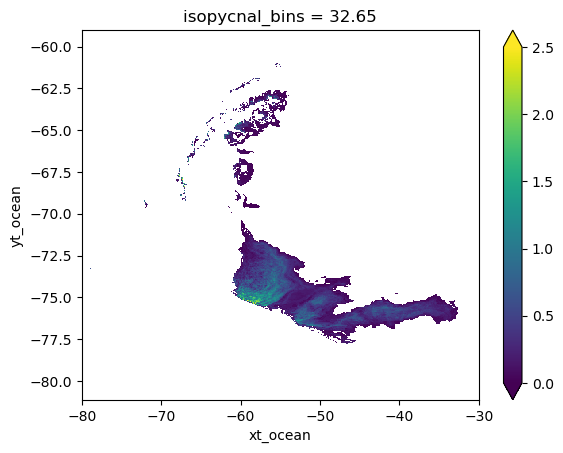

In [75]:
weddell_shelf_subduction_plot.plot(vmin=0, vmax=2.5)

In [29]:
prydz_transformation_density = 32.6

prydz_shelf_subduction_plot = swmt_shelf.sel(isopycnal_bins = prydz_transformation_density, method='nearest') * 1e5
prydz_swmt_xt = prydz_shelf_subduction_plot.xt_ocean
prydz_swmt_yt = prydz_shelf_subduction_plot.yt_ocean

In [30]:
prydz_shelf_subduction_plot = prydz_shelf_subduction_plot.sel(xt_ocean=slice(20,80), yt_ocean=lat_slice)
prydz_swmt_xt = prydz_swmt_xt.sel(xt_ocean=slice(20,80))
prydz_swmt_yt = prydz_swmt_yt.sel(yt_ocean=lat_slice)

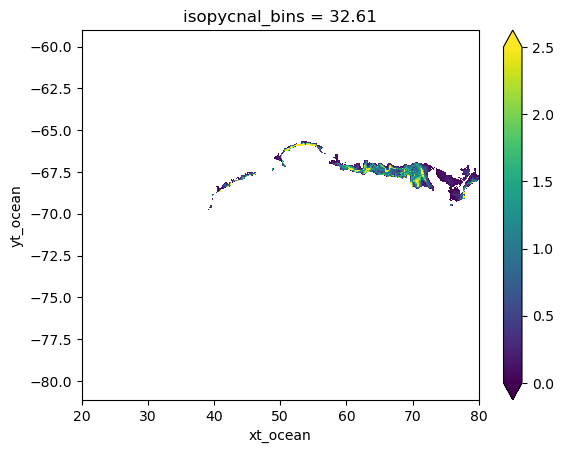

In [71]:
prydz_shelf_subduction_plot.plot(vmin=0, vmax=2.5)

In [31]:
wsbw = xr.open_dataset('/g/data/x77/ps7863/data/AABW_variability/WSBW_tracer_bottom_500_1958-2018.nc')
pbbw = xr.open_dataset('/g/data/x77/ps7863/data/AABW_variability/PBBW_tracer_bottom_500_1958-2018.nc')
pbbw_east = xr.open_dataset('/g/data/x77/ps7863/data/AABW_variability/PBBW_tracer_bottom_500_1958-2018_80-100E.nc')
wsbw = wsbw['WSBW tracer']
pbbw = pbbw['PBBW tracer']
pbbw_east = pbbw_east['__xarray_dataarray_variable__']

In [32]:
wsbw = wsbw.sel(time=time_slice)
pbbw = pbbw.sel(time=time_slice)

In [ ]:
# Load data
rsbw_range = xr.open_dataarray('/g/data/x77/ps7863/data/AABW_variability/RSBW_seasonal_range_1990-2018.nc')
albw_range = xr.open_dataarray('/g/data/x77/ps7863/data/AABW_variability/ALBW_seasonal_range_1990-2018.nc')
wsbw_range = xr.open_dataarray('/g/data/x77/ps7863/data/AABW_variability/WSBW_seasonal_range_1990-2018.nc')
pbbw_range = xr.open_dataarray('/g/data/x77/ps7863/data/AABW_variability/PBBW_seasonal_range_1990-2018.nc')

In [33]:
rsbw_mean = helper.annual_mean_from_monthly(rsbw)
albw_mean = helper.annual_mean_from_monthly(albw)
pbbw_mean = helper.annual_mean_from_monthly(pbbw)
wsbw_mean = helper.annual_mean_from_monthly(wsbw)

In [34]:
rsbw_mean = rsbw_mean.load()
albw_mean = albw_mean.load()
pbbw_mean = pbbw_mean.load()
wsbw_mean = wsbw_mean.load()

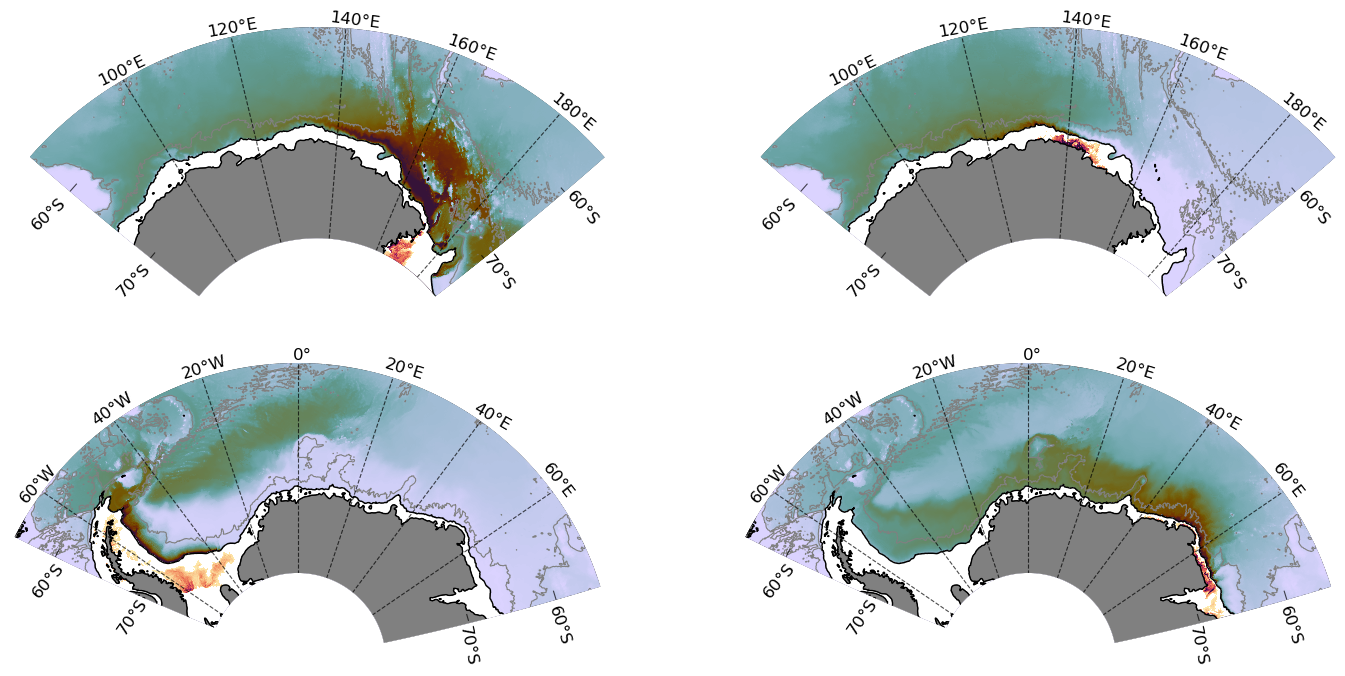

In [85]:
# Define first projection parameters
midlon1 = -225
maxlon1 = midlon1 + 55
minlon1 = midlon1 - 60
minlat1 = -76
maxlat1 = -55
midlat1 = (minlat1 + maxlat1) / 2

projection1 = ccrs.Stereographic(central_longitude=midlon1, central_latitude=midlat1)

# Define second projection parameters
midlon2 = 0
maxlon2 = midlon2 + 80
minlon2 = midlon2 - 70
minlat2 = -80
maxlat2 = -55
midlat2 = (minlat2 + maxlat2) / 2

projection2 = ccrs.Stereographic(central_longitude=midlon2, central_latitude=midlat2)

# Create figure and GridSpec layout (2x2)
fig = plt.figure(figsize=(18, 8))
gs = gridspec.GridSpec(2, 2, figure=fig, wspace=0.1, hspace=0.2)  # Adjust subplot spacing

# Function to create individual subplots
def create_subplot(gs_position, projection, minlon, maxlon, minlat, maxlat):
    ax = fig.add_subplot(gs[gs_position], projection=projection)
    ax.set_extent([minlon, maxlon, minlat, maxlat], crs=ccrs.PlateCarree())
    
    # Select data for the current subplot
    lons = X.sel({"xt_ocean": slice(minlon, maxlon), "yt_ocean": slice(minlat, maxlat)})
    lats = Y.sel({"xt_ocean": slice(minlon, maxlon), "yt_ocean": slice(minlat, maxlat)})
    
    # Generate boundary path
    boundary_path = make_boundary_path(lons, lats)
    ax.add_feature(land_50m)
    ax.coastlines(resolution="50m")
    ax.set_boundary(boundary_path, transform=ccrs.PlateCarree())  
    ax.add_patch(PathPatch(boundary_path, transform=ccrs.PlateCarree(), fc='none', ec='black', lw=1.5))
    ax.spines['geo'].set_visible(False)  

    return ax

cmap = cmcrameri.cm.glasgow_r
norm = mcolors.TwoSlopeNorm(vmin=0, vcenter=0.15, vmax=0.30)

# First subplot (Projection 1)
ax1 = create_subplot((0, 0), projection1, minlon1, maxlon1, minlat1, maxlat1)
plt.pcolormesh(rsbw_mean.xt_ocean+360, rsbw_mean.yt_ocean, rsbw_mean,
               norm=norm,
               transform=ccrs.PlateCarree(),
               cmap=cmap)
ax1.contourf(shelf.xt_ocean, shelf.yt_ocean, shelf, [0.5, 1], transform=ccrs.PlateCarree(), colors='white')
ax1.pcolormesh(ross_SWMT.xt_ocean+360,
              ross_SWMT.yt_ocean,
              ross_SWMT,
              transform=ccrs.PlateCarree(),
              vmin=0, vmax=2.5,
              cmap=cmocean.matter)

# Second subplot (Projection 1)
ax2 = create_subplot((0, 1), projection1, minlon1, maxlon1, minlat1, maxlat1)
plt.pcolormesh(albw_mean.xt_ocean+360, albw_mean.yt_ocean, albw_mean, 
               norm=norm,
               transform=ccrs.PlateCarree(),
               cmap=cmap)
ax2.contourf(shelf.xt_ocean, shelf.yt_ocean, shelf, [0.5, 1], transform=ccrs.PlateCarree(), colors='white')
ax2.pcolormesh(adelie_SWMT.xt_ocean+360,
                  adelie_SWMT.yt_ocean,
                  adelie_SWMT,
                  transform=ccrs.PlateCarree(),
                  vmin=0, vmax=2.5,
                  cmap= cmocean.matter)

# Third subplot (Projection 2)
ax3 = create_subplot((1, 0), projection2, minlon2, maxlon2, minlat2, maxlat2)
plt.pcolormesh(wsbw_mean.xt_ocean+360, wsbw_mean.yt_ocean, wsbw_mean,
               norm=norm,
               transform=ccrs.PlateCarree(),
               cmap=cmap)
ax3.contourf(shelf.xt_ocean, shelf.yt_ocean, shelf, [0.5, 1], transform=ccrs.PlateCarree(), colors='white')
ax3.pcolormesh(weddell_swmt_xt+360, weddell_swmt_yt, weddell_shelf_subduction_plot,
               transform=ccrs.PlateCarree(),
               vmin=0, vmax=2.5,
               cmap= cmocean.matter)


# Fourth subplot (Projection 2)
ax4 = create_subplot((1, 1), projection2, minlon2, maxlon2, minlat2, maxlat2)
plt.pcolormesh(pbbw_mean.xt_ocean+360, pbbw_mean.yt_ocean, pbbw_mean, 
               norm=norm,
               transform=ccrs.PlateCarree(),
               cmap=cmap)
ax4.contourf(shelf.xt_ocean, shelf.yt_ocean, shelf, [0.5, 1], transform=ccrs.PlateCarree(), colors='white')
ax4.pcolormesh(prydz_swmt_xt+360, prydz_swmt_yt, prydz_shelf_subduction_plot,
               transform=ccrs.PlateCarree(),
               vmin=0, vmax=2.5,
               cmap= cmocean.matter
              )

for ax in [ax1, ax2, ax3, ax4]:
    ax.contour(ht.xt_ocean, ht.yt_ocean, ht,
                levels=[3500],
                colors='grey',
                linewidths=.8,
                alpha=1,
                transform=ccrs.PlateCarree())
    
    ax.contour(shelf.xt_ocean, shelf.yt_ocean,shelf,
                [0.5],
                colors = 'k',
                linewidths = 1,
                transform=ccrs.PlateCarree())

for ax in [ax1, ax2]:
        ax.plot([100,100], [-80, -50], linestyle='--', c='k', alpha=0.7, linewidth=0.8, transform=ccrs.PlateCarree())
        ax.plot([120,120], [-80, -50], linestyle='--', c='k', alpha=0.7, linewidth=0.8, transform=ccrs.PlateCarree())
        ax.plot([140,140], [-80, -50], linestyle='--', c='k', alpha=0.7, linewidth=0.8, transform=ccrs.PlateCarree())
        ax.plot([160,160], [-80, -50], linestyle='--', c='k', alpha=0.7, linewidth=0.8, transform=ccrs.PlateCarree())
        ax.plot([180,180], [-80, -50], linestyle='--', c='k', alpha=0.7, linewidth=0.8, transform=ccrs.PlateCarree())
        ax.plot([80,82], [-60, -60], c='k', alpha=0.7, linewidth=0.8, transform=ccrs.PlateCarree())
        ax.plot([80,82], [-70, -70], c='k', alpha=0.7, linewidth=0.8, transform=ccrs.PlateCarree())
        ax.plot([189,190], [-60, -60], c='k', alpha=0.7, linewidth=0.8, transform=ccrs.PlateCarree())
        ax.plot([189,190], [-70, -70], c='k', alpha=0.7, linewidth=0.8, transform=ccrs.PlateCarree())
        
        text_size = 12
        ax.text(96,-54, s=f'100{degree}E', transform=ccrs.PlateCarree(), rotation=26, fontsize=text_size)
        ax.text(116,-54.3, s=f'120{degree}E', transform=ccrs.PlateCarree(), rotation=10, fontsize=text_size)
        ax.text(137,-55, s=f'140{degree}E', transform=ccrs.PlateCarree(), rotation=-7, fontsize=text_size)
        ax.text(158,-56, s=f'160{degree}E', transform=ccrs.PlateCarree(), rotation=-20, fontsize=text_size)
        ax.text(180,-57, s=f'180{degree}E', transform=ccrs.PlateCarree(), rotation=-40, fontsize=text_size)
        
        ax.text(70,-59, s=f'60{degree}S', transform=ccrs.PlateCarree(), rotation=42, fontsize=text_size)
        ax.text(66,-69, s=f'70{degree}S', transform=ccrs.PlateCarree(), rotation=45, fontsize=text_size)
        ax.text(195,-62, s=f'60{degree}S', transform=ccrs.PlateCarree(), rotation=-50, fontsize=text_size)
        ax.text(197,-72, s=f'70{degree}S', transform=ccrs.PlateCarree(), rotation=-53, fontsize=text_size)


for ax in [ax3, ax4]:
    ax.plot([-20,-20], [-80, -50], linestyle='--', c='k', alpha=0.7, linewidth=0.8, transform=ccrs.PlateCarree())
    ax.plot([-40,-40], [-80, -50], linestyle='--', c='k', alpha=0.7, linewidth=0.8, transform=ccrs.PlateCarree())
    ax.plot([-60,-60], [-80, -50], linestyle='--', c='k', alpha=0.7, linewidth=0.8, transform=ccrs.PlateCarree())
    ax.plot([0,0], [-80, -50], linestyle='--', c='k', alpha=0.7, linewidth=0.8, transform=ccrs.PlateCarree())
    ax.plot([20,20], [-80, -50], linestyle='--', c='k', alpha=0.7, linewidth=0.8, transform=ccrs.PlateCarree())
    ax.plot([40,40], [-80, -50], linestyle='--', c='k', alpha=0.7, linewidth=0.8, transform=ccrs.PlateCarree())
    ax.plot([60,60], [-80, -50], linestyle='--', c='k', alpha=0.7, linewidth=0.8, transform=ccrs.PlateCarree())

    ax.plot([-70, -68], [-60, -60], c='k', alpha=0.7, linewidth=0.8, transform=ccrs.PlateCarree())
    ax.plot([-70, -68], [-70, -70], c='k', alpha=0.7, linewidth=0.8, transform=ccrs.PlateCarree())
    ax.plot([78, 80], [-60, -60], c='k', alpha=0.7, linewidth=0.8, transform=ccrs.PlateCarree())
    ax.plot([77, 79], [-70, -70], c='k', alpha=0.7, linewidth=0.8, transform=ccrs.PlateCarree())
    
    ax.text(-64,-53.4, s=f'60{degree}W', transform=ccrs.PlateCarree(), rotation=47, fontsize=text_size)
    ax.text(-44,-53.6, s=f'40{degree}W', transform=ccrs.PlateCarree(), rotation=35, fontsize=text_size)
    ax.text(-24,-54.2, s=f'20{degree}W', transform=ccrs.PlateCarree(), rotation=18, fontsize=text_size)
    ax.text(-1,-54.6, s=f'0{degree}', transform=ccrs.PlateCarree(), rotation=0, fontsize=text_size)
    ax.text(18, -55.5,  s=f'20{degree}E', transform=ccrs.PlateCarree(), rotation=-17, fontsize=text_size)
    ax.text(39, -56.5, s=f'40{degree}E', transform=ccrs.PlateCarree(), rotation=-30, fontsize=text_size)
    ax.text(59, -56.6, s=f'60{degree}E', transform=ccrs.PlateCarree(), rotation=-52, fontsize=text_size)
    
    ax.text(-80,-59, s=f'60{degree}S', transform=ccrs.PlateCarree(), rotation=50, fontsize=text_size)
    ax.text(-84,-69, s=f'70{degree}S', transform=ccrs.PlateCarree(), rotation=55, fontsize=text_size)
    ax.text(89,-62, s=f'60{degree}S', transform=ccrs.PlateCarree(), rotation=-72, fontsize=text_size)
    ax.text(93,-72, s=f'70{degree}S', transform=ccrs.PlateCarree(), rotation=-79, fontsize=text_size)

    
plt.tight_layout()

plt.savefig(f'{figdir}/AABW_sources_mean_concentration.png', dpi=300)


## Use model land mask

In [35]:
bathymetry = ht.load()
land = xr.where(np.isnan(bathymetry.rename("land")), 1, np.nan)
# land = land.assign_coords({"geolon_t": geolon_t, "geolat_t": geolat_t})

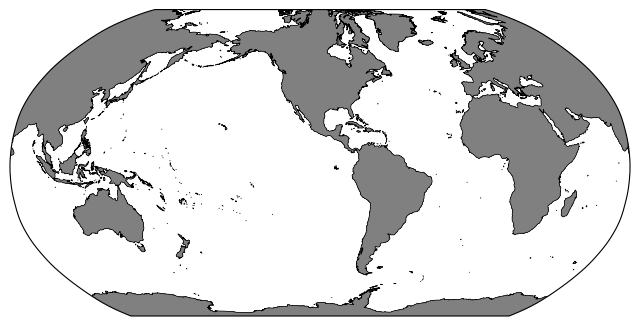

In [93]:
fig = plt.figure(figsize=(8, 4))
ax = plt.axes(projection=ccrs.Robinson(central_longitude=-100))
land.plot.contourf(
    ax=ax,
    x="xt_ocean",
    y="yt_ocean",
    colors="grey",
    zorder=2, transform=ccrs.PlateCarree(), add_colorbar=False
)

# Add model coastline
land.fillna(0).plot.contour(
    ax=ax,
    x="xt_ocean",
    y="yt_ocean",
    colors="k",
    levels=[0, 1],
    transform=ccrs.PlateCarree(), add_colorbar=False,
    linewidths=0.5,
)

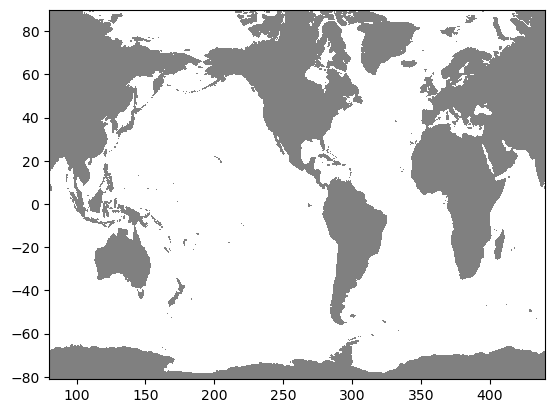

In [96]:
plt.contourf(land.xt_ocean+360, land.yt_ocean, land,
             colors='grey'
            )

In [ ]:
# Define first projection parameters
midlon1 = -225
maxlon1 = midlon1 + 55
minlon1 = midlon1 - 60
minlat1 = -76
maxlat1 = -55
midlat1 = (minlat1 + maxlat1) / 2

projection1 = ccrs.Stereographic(central_longitude=midlon1, central_latitude=midlat1)

# Define second projection parameters
midlon2 = 0
maxlon2 = midlon2 + 80
minlon2 = midlon2 - 70
minlat2 = -80
maxlat2 = -55
midlat2 = (minlat2 + maxlat2) / 2

projection2 = ccrs.Stereographic(central_longitude=midlon2, central_latitude=midlat2)

# Create figure and GridSpec layout (2x2)
fig = plt.figure(figsize=(18, 8))
gs = gridspec.GridSpec(2, 2, figure=fig, wspace=0.1, hspace=0.2)  # Adjust subplot spacing

# Function to create individual subplots
def create_subplot(gs_position, projection, minlon, maxlon, minlat, maxlat):
    ax = fig.add_subplot(gs[gs_position], projection=projection)
    ax.set_extent([minlon, maxlon, minlat, maxlat], crs=ccrs.PlateCarree())
    
    # Select data for the current subplot
    lons = X.sel({"xt_ocean": slice(minlon, maxlon), "yt_ocean": slice(minlat, maxlat)})
    lats = Y.sel({"xt_ocean": slice(minlon, maxlon), "yt_ocean": slice(minlat, maxlat)})
    
    # Generate boundary path
    boundary_path = make_boundary_path(lons, lats)
    # ax.add_feature(land_50m)
    # ax.coastlines(resolution="50m")
    ax.set_boundary(boundary_path, transform=ccrs.PlateCarree())  
    ax.add_patch(PathPatch(boundary_path, transform=ccrs.PlateCarree(), fc='none', ec='black', lw=1.5))
    ax.spines['geo'].set_visible(True)  
    ax.contourf(land.xt_ocean+360, land.yt_ocean, land,
         transform=ccrs.PlateCarree(),
         colors='grey'
        )

    return ax

cmap = cmcrameri.cm.glasgow_r
norm = mcolors.TwoSlopeNorm(vmin=0, vcenter=0.15, vmax=0.30)

# First subplot (Projection 1)
ax1 = create_subplot((0, 0), projection1, minlon1, maxlon1, minlat1, maxlat1)
pc = plt.pcolormesh(rsbw_mean.xt_ocean+360, rsbw_mean.yt_ocean, rsbw_mean,
               norm=norm,
               transform=ccrs.PlateCarree(),
               cmap=cmap)
ax1.contourf(shelf.xt_ocean, shelf.yt_ocean, shelf, [0.5, 1], transform=ccrs.PlateCarree(), colors='white')
pc_swmt = ax1.pcolormesh(ross_SWMT.xt_ocean+360,
              ross_SWMT.yt_ocean,
              ross_SWMT,
              transform=ccrs.PlateCarree(),
              vmin=0, vmax=2.5,
             cmap=cmocean.matter)

# Second subplot (Projection 1)
ax2 = create_subplot((0, 1), projection1, minlon1, maxlon1, minlat1, maxlat1)
plt.pcolormesh(albw_mean.xt_ocean+360, albw_mean.yt_ocean, albw_mean, 
               norm=norm,
               transform=ccrs.PlateCarree(),
               cmap=cmap)
ax2.contourf(shelf.xt_ocean, shelf.yt_ocean, shelf, [0.5, 1], transform=ccrs.PlateCarree(), colors='white')
ax2.pcolormesh(adelie_SWMT.xt_ocean+360,
                  adelie_SWMT.yt_ocean,
                  adelie_SWMT,
                  transform=ccrs.PlateCarree(),
                  vmin=0, vmax=2.5,
                  cmap= cmocean.matter)

# Third subplot (Projection 2)
ax3 = create_subplot((1, 0), projection2, minlon2, maxlon2, minlat2, maxlat2)
plt.pcolormesh(wsbw_mean.xt_ocean+360, wsbw_mean.yt_ocean, wsbw_mean,
               norm=norm,
               transform=ccrs.PlateCarree(),
               cmap=cmap)
ax3.contourf(shelf.xt_ocean, shelf.yt_ocean, shelf, [0.5, 1], transform=ccrs.PlateCarree(), colors='white')
ax3.pcolormesh(weddell_swmt_xt+360, weddell_swmt_yt, weddell_shelf_subduction_plot,
               transform=ccrs.PlateCarree(),
               vmin=0, vmax=2.5,
               cmap= cmocean.matter)


# Fourth subplot (Projection 2)
ax4 = create_subplot((1, 1), projection2, minlon2, maxlon2, minlat2, maxlat2)

plt.pcolormesh(pbbw_mean.xt_ocean+360, pbbw_mean.yt_ocean, pbbw_mean, 
               norm=norm,
               transform=ccrs.PlateCarree(),
               cmap=cmap)
ax4.contourf(shelf.xt_ocean, shelf.yt_ocean, shelf, [0.5, 1], transform=ccrs.PlateCarree(), colors='white')
# plot SWMT in Prydz Bay
ax4.pcolormesh(prydz_swmt_xt+360, prydz_swmt_yt, prydz_shelf_subduction_plot,
               transform=ccrs.PlateCarree(),
               vmin=0, vmax=2.5,
               cmap= cmocean.matter
             )


cbar_ax1 = fig.add_axes([0.1, 0.52, 0.01, 0.35])  # [left, bottom, width, height]
cbar_ax2 = fig.add_axes([0.1, 0.1, 0.01, 0.35])  # under the first colobar

cbar1 = plt.colorbar(pc, cax=cbar_ax1,
                     orientation='vertical',
                     spacing='proportional',
                     ticks=[0, .05, .1, .15, .2, .25, .3],
                     extend='max',
                     location='left'
                    )
cbar1.set_label('Tracer concentration', fontsize=12)

cbar2 = plt.colorbar(pc_swmt, cax=cbar_ax2,
                     orientation='vertical',
                     spacing='proportional',
                     extend='max',
                     location='left'
                    )
cbar2.set_label(r'Surface water-mass transformation [$\times 10^{-5}$m s$^{-1}$]', fontsize=12)


for ax in [ax1, ax2, ax3, ax4]:
    ax.contour(ht.xt_ocean, ht.yt_ocean, ht,
                levels=[3500],
                colors='dimgray',
                linewidths=.6,
                alpha=1,
                transform=ccrs.PlateCarree())
    
    ax.contour(shelf.xt_ocean, shelf.yt_ocean,shelf,
                [0.5],
                colors = 'k',
                linewidths = 1,
                transform=ccrs.PlateCarree())
    ax.contourf(land.xt_ocean+360, land.yt_ocean, land,
         transform=ccrs.PlateCarree(),
         colors='grey'
        )

for ax in [ax1, ax2]:
        ax.plot([100,100], [-80, -50], linestyle='--', c='k', alpha=0.7, linewidth=0.8, transform=ccrs.PlateCarree())
        ax.plot([120,120], [-80, -50], linestyle='--', c='k', alpha=0.7, linewidth=0.8, transform=ccrs.PlateCarree())
        ax.plot([140,140], [-80, -50], linestyle='--', c='k', alpha=0.7, linewidth=0.8, transform=ccrs.PlateCarree())
        ax.plot([160,160], [-80, -50], linestyle='--', c='k', alpha=0.7, linewidth=0.8, transform=ccrs.PlateCarree())
        ax.plot([180,180], [-80, -50], linestyle='--', c='k', alpha=0.7, linewidth=0.8, transform=ccrs.PlateCarree())
        ax.plot([80,82], [-60, -60], c='k', alpha=0.7, linewidth=0.8, transform=ccrs.PlateCarree())
        ax.plot([80,82], [-70, -70], c='k', alpha=0.7, linewidth=0.8, transform=ccrs.PlateCarree())
        ax.plot([189,190], [-60, -60], c='k', alpha=0.7, linewidth=0.8, transform=ccrs.PlateCarree())
        ax.plot([189,190], [-70, -70], c='k', alpha=0.7, linewidth=0.8, transform=ccrs.PlateCarree())
        
        text_size = 12
        ax.text(96,-54, s=f'100{degree}E', transform=ccrs.PlateCarree(), rotation=26, fontsize=text_size)
        ax.text(116,-54.3, s=f'120{degree}E', transform=ccrs.PlateCarree(), rotation=10, fontsize=text_size)
        ax.text(137,-55, s=f'140{degree}E', transform=ccrs.PlateCarree(), rotation=-7, fontsize=text_size)
        ax.text(158,-56, s=f'160{degree}E', transform=ccrs.PlateCarree(), rotation=-20, fontsize=text_size)
        ax.text(180,-57, s=f'180{degree}E', transform=ccrs.PlateCarree(), rotation=-40, fontsize=text_size)
        
        ax.text(70,-59, s=f'60{degree}S', transform=ccrs.PlateCarree(), rotation=42, fontsize=text_size)
        ax.text(66,-69, s=f'70{degree}S', transform=ccrs.PlateCarree(), rotation=45, fontsize=text_size)
        ax.text(195,-62, s=f'60{degree}S', transform=ccrs.PlateCarree(), rotation=-50, fontsize=text_size)
        ax.text(197,-72, s=f'70{degree}S', transform=ccrs.PlateCarree(), rotation=-53, fontsize=text_size)


for ax in [ax3, ax4]:
    ax.plot([-20,-20], [-80, -50], linestyle='--', c='k', alpha=0.7, linewidth=0.8, transform=ccrs.PlateCarree())
    ax.plot([-40,-40], [-80, -50], linestyle='--', c='k', alpha=0.7, linewidth=0.8, transform=ccrs.PlateCarree())
    ax.plot([-60,-60], [-80, -50], linestyle='--', c='k', alpha=0.7, linewidth=0.8, transform=ccrs.PlateCarree())
    ax.plot([0,0], [-80, -50], linestyle='--', c='k', alpha=0.7, linewidth=0.8, transform=ccrs.PlateCarree())
    ax.plot([20,20], [-80, -50], linestyle='--', c='k', alpha=0.7, linewidth=0.8, transform=ccrs.PlateCarree())
    ax.plot([40,40], [-80, -50], linestyle='--', c='k', alpha=0.7, linewidth=0.8, transform=ccrs.PlateCarree())
    ax.plot([60,60], [-80, -50], linestyle='--', c='k', alpha=0.7, linewidth=0.8, transform=ccrs.PlateCarree())

    ax.plot([-70, -68], [-60, -60], c='k', alpha=0.7, linewidth=0.8, transform=ccrs.PlateCarree())
    ax.plot([-70, -68], [-70, -70], c='k', alpha=0.7, linewidth=0.8, transform=ccrs.PlateCarree())
    ax.plot([78, 80], [-60, -60], c='k', alpha=0.7, linewidth=0.8, transform=ccrs.PlateCarree())
    ax.plot([77, 79], [-70, -70], c='k', alpha=0.7, linewidth=0.8, transform=ccrs.PlateCarree())
    
    ax.text(-64,-53.4, s=f'60{degree}W', transform=ccrs.PlateCarree(), rotation=47, fontsize=text_size)
    ax.text(-44,-53.6, s=f'40{degree}W', transform=ccrs.PlateCarree(), rotation=35, fontsize=text_size)
    ax.text(-24,-54.2, s=f'20{degree}W', transform=ccrs.PlateCarree(), rotation=18, fontsize=text_size)
    ax.text(-1,-54.6, s=f'0{degree}', transform=ccrs.PlateCarree(), rotation=0, fontsize=text_size)
    ax.text(18, -55.5,  s=f'20{degree}E', transform=ccrs.PlateCarree(), rotation=-17, fontsize=text_size)
    ax.text(39, -56.5, s=f'40{degree}E', transform=ccrs.PlateCarree(), rotation=-30, fontsize=text_size)
    ax.text(59, -56.6, s=f'60{degree}E', transform=ccrs.PlateCarree(), rotation=-52, fontsize=text_size)
    
    ax.text(-80,-59, s=f'60{degree}S', transform=ccrs.PlateCarree(), rotation=50, fontsize=text_size)
    ax.text(-84,-69, s=f'70{degree}S', transform=ccrs.PlateCarree(), rotation=55, fontsize=text_size)
    ax.text(89,-62, s=f'60{degree}S', transform=ccrs.PlateCarree(), rotation=-72, fontsize=text_size)
    ax.text(93,-72, s=f'70{degree}S', transform=ccrs.PlateCarree(), rotation=-79, fontsize=text_size)


    
plt.tight_layout()

plt.savefig(f'{figdir}/AABW_sources_mean_concentration.png', dpi=300)


In [40]:
def identify_axes(ax_dict, fontsize=48):
    """
    Helper to identify the Axes in the examples below.

    Draws the label in a large font in the center of the Axes.

    Parameters
    ----------
    ax_dict : dict[str, Axes]
        Mapping between the title / label and the Axes.
    fontsize : int, optional
        How big the label should be.
    """
    kw = dict(ha="center", va="center", fontsize=fontsize, color="darkgrey")
    for k, ax in ax_dict.items():
        ax.text(0.5, 0.5, k, transform=ax.transAxes, **kw)

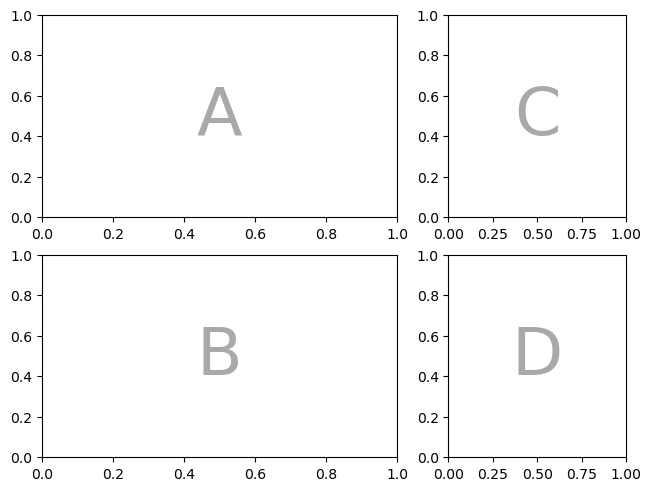

In [14]:
axd = plt.figure(layout="constrained").subplot_mosaic(
    """
    AAC
    BBD
    """
)
identify_axes(axd)

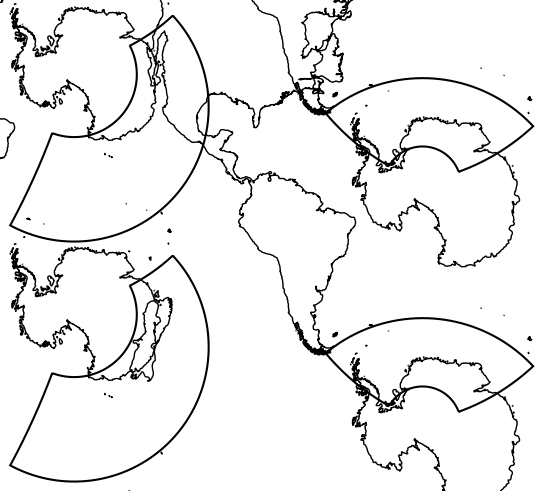

In [22]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from matplotlib.patches import PathPatch

# Define first projection parameters
midlon1 = -225
maxlon1 = midlon1 + 60
minlon1 = midlon1 - 60
minlat1 = -72
maxlat1 = -55
midlat1 = (minlat1 + maxlat1) / 2

projection1 = ccrs.Stereographic(central_longitude=midlon1, central_latitude=midlat1)

# Define second projection parameters
midlon2 = 0
maxlon2 = midlon2 + 80
minlon2 = midlon2 - 70
minlat2 = -80
maxlat2 = -55
midlat2 = (minlat2 + maxlat2) / 2

projection2 = ccrs.Stereographic(central_longitude=midlon2, central_latitude=midlat2)

# ✅ Corrected `subplot_mosaic` implementation
fig = plt.figure(layout="constrained")
axd = fig.subplot_mosaic(
    """
    AAC
    BBD
    """,
    subplot_kw={"projection": ccrs.Stereographic()}  # ✅ Fix: Define projection
)

# Function to create and configure subplots
def create_subplot(ax, projection, minlon, maxlon, minlat, maxlat):
    ax.set_extent([minlon, maxlon, minlat, maxlat], crs=ccrs.PlateCarree())
    
    # Select data for the current subplot
    lons = X.sel({"xt_ocean": slice(minlon, maxlon), "yt_ocean": slice(minlat, maxlat)})
    lats = Y.sel({"xt_ocean": slice(minlon, maxlon), "yt_ocean": slice(minlat, maxlat)})
    
    # Generate boundary path
    boundary_path = make_boundary_path(lons, lats)

    # Clip the map to boundary
    ax.set_boundary(boundary_path, transform=ccrs.PlateCarree())  

    # Draw coastlines (inside the boundary only)
    ax.coastlines()

    # ✅ Add visible boundary outline
    ax.add_patch(PathPatch(boundary_path, transform=ccrs.PlateCarree(), fc='none', ec='black', lw=1.5))

    # Remove the subplot frame
    ax.spines['geo'].set_visible(False)  

    return ax

# First subplot - Projection 1 (A)
axd["A"] = fig.add_subplot(axd["A"], projection=projection1)
create_subplot(axd["A"], projection1, minlon1, maxlon1, minlat1, maxlat1)

# Second subplot - Projection 1 (B)
axd["B"] = fig.add_subplot(axd["B"], projection=projection1)
create_subplot(axd["B"], projection1, minlon1, maxlon1, minlat1, maxlat1)

# Third subplot - Projection 2 (C)
axd["C"] = fig.add_subplot(axd["C"], projection=projection2)
create_subplot(axd["C"], projection2, minlon2, maxlon2, minlat2, maxlat2)

# Fourth subplot - Projection 2 (D)
axd["D"] = fig.add_subplot(axd["D"], projection=projection2)
create_subplot(axd["D"], projection2, minlon2, maxlon2, minlat2, maxlat2)

# Show the final layout
plt.show()
